### Titre
-  

### Présenter par :
-  
-  

### But du TP
-  
-  
-  

### Introduction (NMF) : 
-  
-  
-  

In [1]:
# import needed librery
import numpy as np
import librosa as lb
import librosa
from librosa import display
import os
import re
import matplotlib.pyplot as plt
import tqdm 
from IPython.display import Audio


### Help functions

In [2]:
def plot_audio_waves(waves,
                    suptitle='audio waves from different sources separately as a function of time',
                    nb_plots=3, 
                    grid=True, 
                    total_cols=4, 
                    figsize=(15, 10)):
    """  
    @ Parametes : 
    -------------
    showing waves as grid, 
    waves      : Image dataset
    suptitle   : // 
    nb_plots   : Number of images to display
    grid       : Boulen indicating whether the figure will be in grid mode or not  
    total_cols : Desired number of columns
    figsize    : The dimensions of the figure 

    @ Retuen :
    ----------
    None
    """
    assert len(list(waves)) > 0

    # compute number of cols & row  
    total_cols    = min(nb_plots, total_cols)
    total_rows    = int(nb_plots / total_cols) + (1 if nb_plots % total_cols != 0 else 0)
    # Create a grid of subplots.
    fig, axes = plt.subplots(total_rows, total_cols, figsize=figsize)
    # Create list of axes for easy iteration.
    if isinstance(axes, np.ndarray):
        # https://stackoverflow.com/questions/46862861/what-does-axes-flat-in-matplotlib-do
        list_axes = list(axes.flat)
    else:
        list_axes = [axes]
    # it will helps to show total images as grid 

    for (key, val), ax in zip(waves.items(), list_axes):
        ax.plot(val, label=key)
        ax.set(label=key, xlabel='Time [s]')
        ax.grid(grid)
        ax.legend()
    plt.suptitle(suptitle)
    plt.show()


def show_audio_spectrogrammes(W_H,
                              sr,
                              suptitle='the evolution of the matrices W, H, and the approximated spectrogram V as a function of the iterations',
                              nb_plots=3, 
                              total_cols=4, 
                              colorbar=False,
                              figsize=(15, 10)):
    """  
    @ Parametes : 
    -------------
    showing waves as grid, 
    W_H        : Image dataset
    suptitle   : //
    nb_plots   : Number of images to display
    total_cols : Desired number of columns
    colorbar   : // 
    figsize    : The dimensions of the figure 

    @ Retuen :
    ----------
    None
    """
    assert len(list(W_H)) > 0

    # compute number of cols & row  
    total_cols    = min(nb_plots, total_cols)
    total_rows    = int(nb_plots / total_cols) + (1 if nb_plots % total_cols != 0 else 0)
    # Create a grid of subplots.
    fig, axes = plt.subplots(total_rows, total_cols, figsize=figsize)
    # Create list of axes for easy iteration.
    if isinstance(axes, np.ndarray):
        # https://stackoverflow.com/questions/46862861/what-does-axes-flat-in-matplotlib-do
        list_axes = list(axes.flat)
    else:
        list_axes = [axes]
    # it will helps to show total images as grid 

    # keys = [i for i in range(n_iter) if not(i % n)]
    key_list = list(W_H.keys())[0:-1:2]
    keys = ' '.join(key_list)
    keys = re.findall(r'\d+', keys)
    
    for i, key in zip(range(0, nb_plots, total_cols), keys):
        
        W, H = W_H['W'+str(key)], W_H['H'+str(key)]
        V = W @ H
        
        w = lb.display.specshow(W, x_axis='time',
                            y_axis='mel', sr=sr,
                            fmax=None, ax=list_axes[i])
        
        list_axes[i].set(title='W'+str(key))
        
        h = lb.display.specshow(H, x_axis='time',
                            y_axis='mel', sr=sr,
                            fmax=None, ax=list_axes[i+1])
        list_axes[i+1].set(title='H'+str(key))

        v = lb.display.specshow(V, x_axis='time',
                            y_axis='mel', sr=sr,
                            fmax=None, ax=list_axes[i+2])
        list_axes[i+2].set(title=f'V{key} = W{key} @ H{key}')

        if colorbar:
            fig.colorbar(w, ax=list_axes[i], format='%+2.0f dB')
            fig.colorbar(h, ax=list_axes[i+1], format='%+2.0f dB')
            fig.colorbar(v, ax=list_axes[i+2], format='%+2.0f dB')

    plt.suptitle(suptitle)
            

def nmf(V, nb_sources, n_iter=50, B=2, n=10):

    """  
    @ Parametes : 
    -------------
    V          : //
    nb_sources : 
    B          : constante of the betha-divergence 
    n_iter     : number of iterations for learning  
    n          : storage rate of matrices X and H    

    @ Retuen :
    ----------
    None
    """

    assert B in [0, 1, 2]

    K, N = V.shape
    # inisialisation of the two matric H and W with positive random numbers between [0, 1[
    W = np.random.rand(K, nb_sources)
    H = np.random.rand(nb_sources, N)
    

    loss = []      # list to stack the learning errors for each iteration 
    W_H = {}       # dictionary to save the W and H matrices for each "n" of the training   

    # These two matrices are useful to avoid infinite values when calculating W, H and the error
    eps  = 10**(-12)
    eps1 = eps * np.ones((K, nb_sources))
    eps2 = eps * np.ones((nb_sources, N))

    for i in tqdm.tqdm(range(n_iter)):
        # Update of the two matrices W and H
        W = W * (((((W @ H)**(B-2)) * V) @ H.T) / (((W @ H)**(B-1)) @ H.T + eps1))
        H = H * ((W.T @ (((W @ H)**(B-2)) * V)) / (W.T @ ((W @ H)**(B-1)) + eps2))

        if B == 2:
            # Calculation of the error for each iteration 
            # cost = 1/(B * (B - 1 + eps)) * (np.sum(V**(B) + (B - 1) * (W @ H)**(B) - B * V * (W @ H)**(B-1)))
            cost = 1/2 * np.sum((V - (W@H))**2)
        elif B == 1:
            # Calculation of the error for each iteration 
            cost = np.sum((V/(W@H)) - np.log(V/(W@H)) - 1)
        elif B == 0:
            # Calculation of the error for each iteration 
            cost = np.sum(V * np.log(V/(W@H)) + (W@H - V))
        loss.append(cost)

        # storage of matrices w and H  
        if not (i % n) :
            W_H['W'+str(i)] = W
            W_H['H'+str(i)] = H
    
    return (W_H, loss)


    

### TP

In [3]:
# Extract the current path
current_path = os.path.dirname(os.path.abspath('__file__'))
current_path

'c:\\Users\\Brani\\Downloads\\Sound-processing-Master-ISI-Sorbonne-University-\\TP03_NMF_algorithm'

 $Q1$

In [4]:
# loading a sound file 
full_path_soud_file = os.path.join(current_path, 'audio')
file_name = 'piano_mix.wav'

piano_sound, sr = librosa.load(os.path.join(full_path_soud_file, file_name), sr=None)
piano_sound

array([ 0.00054932,  0.00067139,  0.00076294, ..., -0.00335693,
       -0.00286865, -0.00222778], dtype=float32)

In [5]:
# display audio
Audio(data=piano_sound, rate=sr)

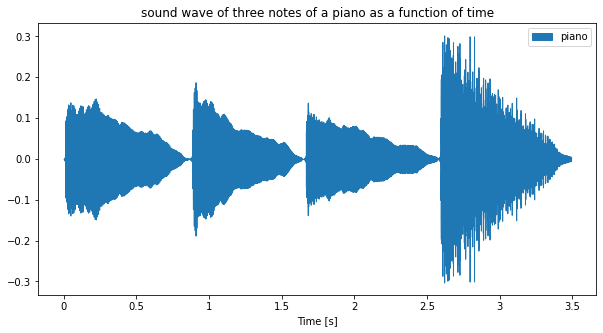

In [6]:
# Tracing the waveform
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(10, 5))
display.waveshow(piano_sound, sr=sr, ax=ax, label='piano',x_axis='time')
ax.set(title='sound wave of three notes of a piano as a function of time',
       xlabel='Time [s]')
ax.legend()


- Commentaire sur la forme de l'onde   
- Peut-on déduire le nombe de notes seulement avec la representation temporelle ?   
- Est-ce que peut-on dir que c'est une note issu d'un instrument de music musicale à première vue ?   

In [7]:
# plotting the spectrogram as a function of frequency (in Hz.) and time (in s.)

stft = lb.stft(piano_sound)                     # Short-time Fourier transform of piano sound
V = np.abs(stft)                                # the module of Short-time Fourier transform of piano sound
P = np.angle(stft)                              # The phase of of Short-time Fourier transform of piano sound
S = lb.feature.melspectrogram(S=V, sr=sr)       # The mel-spectrogram of Short-time Fourier transform of piano sound

V.shape

(1025, 301)

- Qu'est ce que l'echèle mel ?
- Commentaire sur les dimension du spectograme de module (nb source et nb micropnone)
- Si N > K ==> ?, Si N <> K ==> ou si Si N == K ==> ? (expliquer le phénomène)   

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

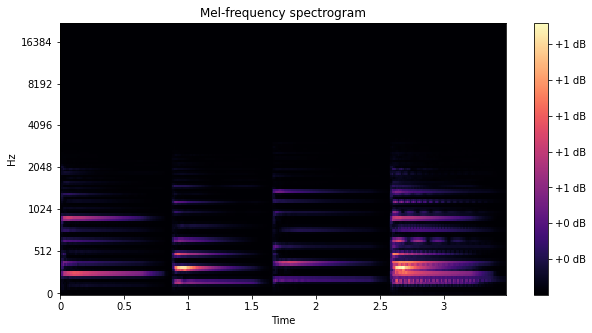

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
# S_dB = lb.power_to_db(S, ref=np.max)
img = lb.display.specshow(S, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=None, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

- Qu'est ce que un spectrograme ? 
- A quoi est-il utile pour l'aplication de NMF ? 
- Commentaire sur la forme du spectrograme   
- Peut-on déduire le nombe de notes seulement avec la representation du spectrograme ?   
- Est-ce que peut-on dir que c'est une note issu d'un instrument de music musicale à première vue ?  

$Q2$

In [9]:
# inisialisation of the dimensions of the two matric H and W

K, N = V.shape
S = 3

K, N

(1025, 301)

In [10]:
# inisialisation of the two matric H and W with positive random numbers between [0, 1[

W = np.random.rand(K, S)
H = np.random.rand(S, N)
W.shape , H.shape

((1025, 3), (3, 301))

In [11]:
W_H, loss = nmf(V=V, nb_sources=S, n_iter=50, B=2, n=10)

100%|██████████| 50/50 [00:00<00:00, 57.74it/s]


- C'est Quoi betha-divergence
- C'est quoi la fonction cout que nous avons utiliser, quel est son avantage notre aplication (NMF)

$Q3$

In [12]:
total_cols = 3
nb_plots = len(list(W_H))//2 * total_cols
figsize = (20, 30)

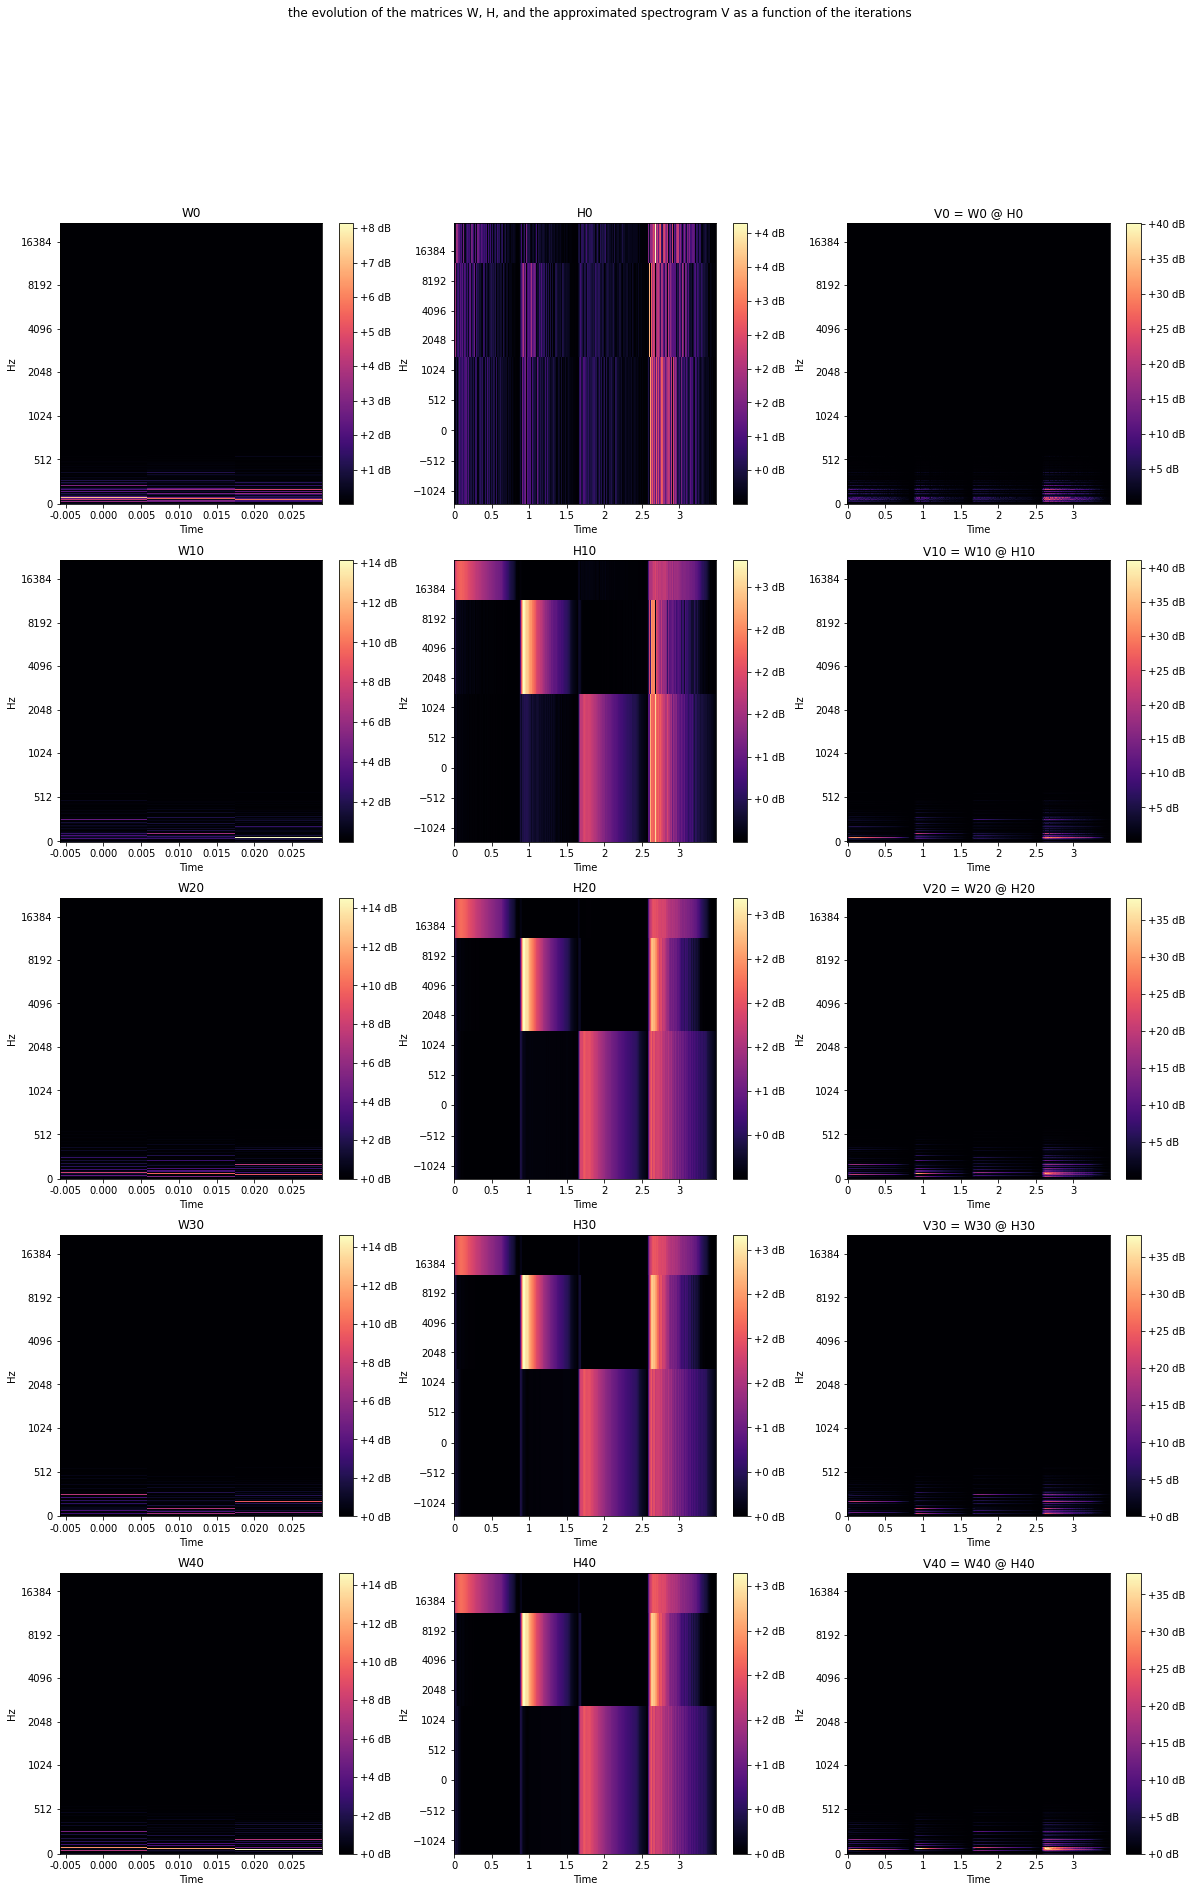

In [13]:
show_audio_spectrogrammes(W_H,
                          sr=sr,
                          suptitle='the evolution of the matrices W, H, and the approximated spectrogram V as a function of the iterations',
                          nb_plots=nb_plots, 
                          total_cols=total_cols, 
                          colorbar=True,
                          figsize=figsize)

- Qu’observe-t-on ? Est-ce attendu ?  

$Q4$

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


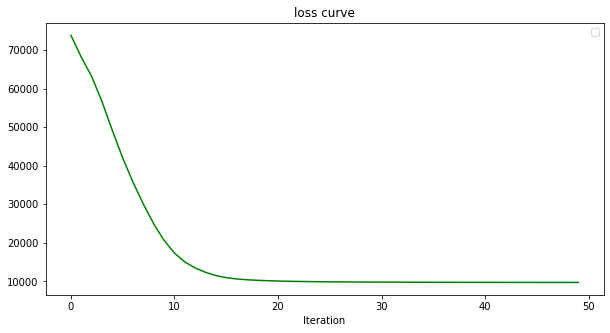

In [14]:
# 2.d) display of the loss curve for each 'n' iteration

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(10, 5))
ax.set(title='loss curve', xlabel='Iteration')
ax.legend()
ax.plot(loss, color='g')

- Commenter la courbe 
- Pour quoi la courbe de loss n'oscille jamais ! (On a vue 2 preuves lors de la scéance de tp)
- Qu’observe-t-on ? Est-ce attendu ?      

$Q5$

In [15]:
# From the matrices W, H, We implement the Wiener filtering to 
# calculate the spectrogram of the sound sources separately.
best_W, best_H = W_H['W40'], W_H['H40']
spectrogramme_of_sources = {}
for i in range(S):
    spectrogramme_of_sources['source ' + str(i)] = ((best_W[:, i].reshape(K, 1) @ best_H[i, :].reshape(1, N))/(best_W @ best_H)) * stft

In [16]:
total_cols = 3
nb_plots = S 
figsize = (20, 5)

c:\Users\Brani\anaconda3\envs\env_ML\lib\site-packages\librosa\util\decorators.py:88: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  return f(*args, **kwargs)


Text(0.5, 0.98, 'spectrogramme of sources')

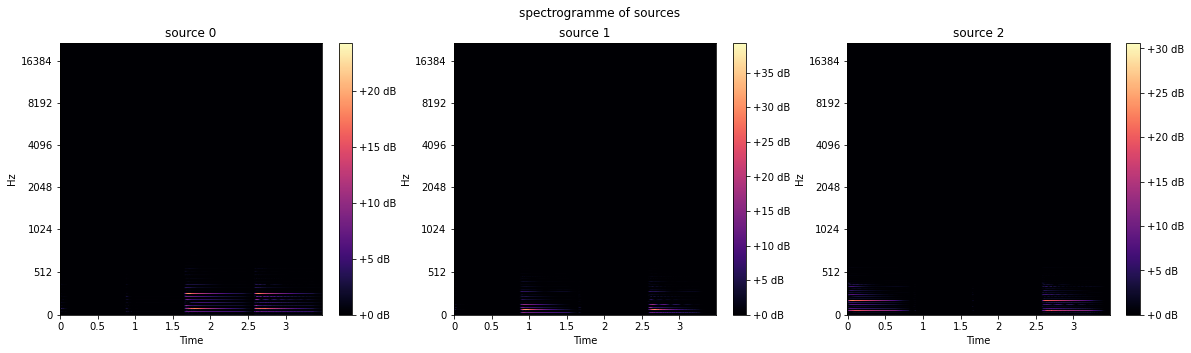

In [17]:
# Plot the evolution of the matrices W, H, and the approximated 
# spectrogram V as a function of the iterations

# compute number of cols & row  
# total_cols    = min(nb_axes, total_cols)
total_rows    = int(nb_plots / total_cols) + (1 if nb_plots % total_cols != 0 else 0)
# Create a grid of subplots.
fig, axes = plt.subplots(total_rows, total_cols, figsize=figsize)
# Create list of axes for easy iteration.
if isinstance(axes, np.ndarray):
    # https://stackoverflow.com/questions/46862861/what-does-axes-flat-in-matplotlib-do
    list_axes = list(axes.flat)
else:
    list_axes = [axes]
# it will helps to show total images as grid 

for (key, val), ax in zip(spectrogramme_of_sources.items(), list_axes):
    
    s = lb.display.specshow(val, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=None, ax=ax)
    ax.set(title= key)
    fig.colorbar(s, ax=ax, format='%+2.0f dB')
plt.suptitle('spectrogramme of sources')
    



- Commentaires : 
-   
-  

$Q6$

In [18]:
# We will reconstruct the corresponding waveforms from the sound sources
# soectrograms. We will use the inverse short-time Fourier transform.

sound_waves = {}

for (_, val), i in zip(spectrogramme_of_sources.items(), range(len(list(spectrogramme_of_sources)))):
    sound_waves[f'sound {i}'] = librosa.istft(val)

In [19]:
total_cols = 1
nb_plots = S

figsize = (15, 15)

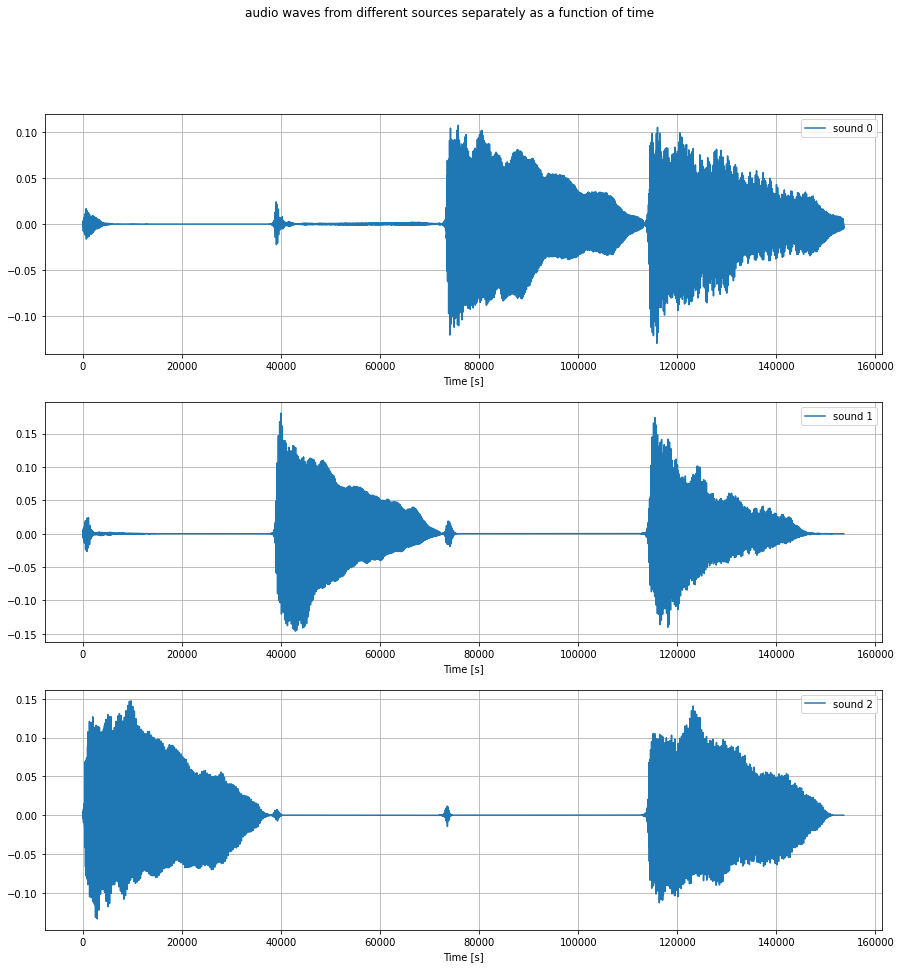

In [20]:
plot_audio_waves(waves=sound_waves,
                 suptitle='audio waves from different sources separately as a function of time', 
                 nb_plots=nb_plots, 
                 grid=True, 
                 total_cols=total_cols, 
                 figsize=figsize)


In [21]:
# display source 0
Audio(data=sound_waves['sound 0'], rate=sr)

In [22]:
# display source 1
Audio(data=sound_waves['sound 1'], rate=sr)

In [23]:
# display source 2
Audio(data=sound_waves['sound 2'], rate=sr)

$Q7$

b = 1 puis 0 ...  

In [24]:
W_H, loss = nmf(V=V, nb_sources=S, n_iter=50, B=1, n=10)


100%|██████████| 50/50 [00:00<00:00, 54.31it/s]


In [25]:
total_cols = 3
nb_plots = len(list(W_H))//2 * total_cols
figsize = (20, 30)

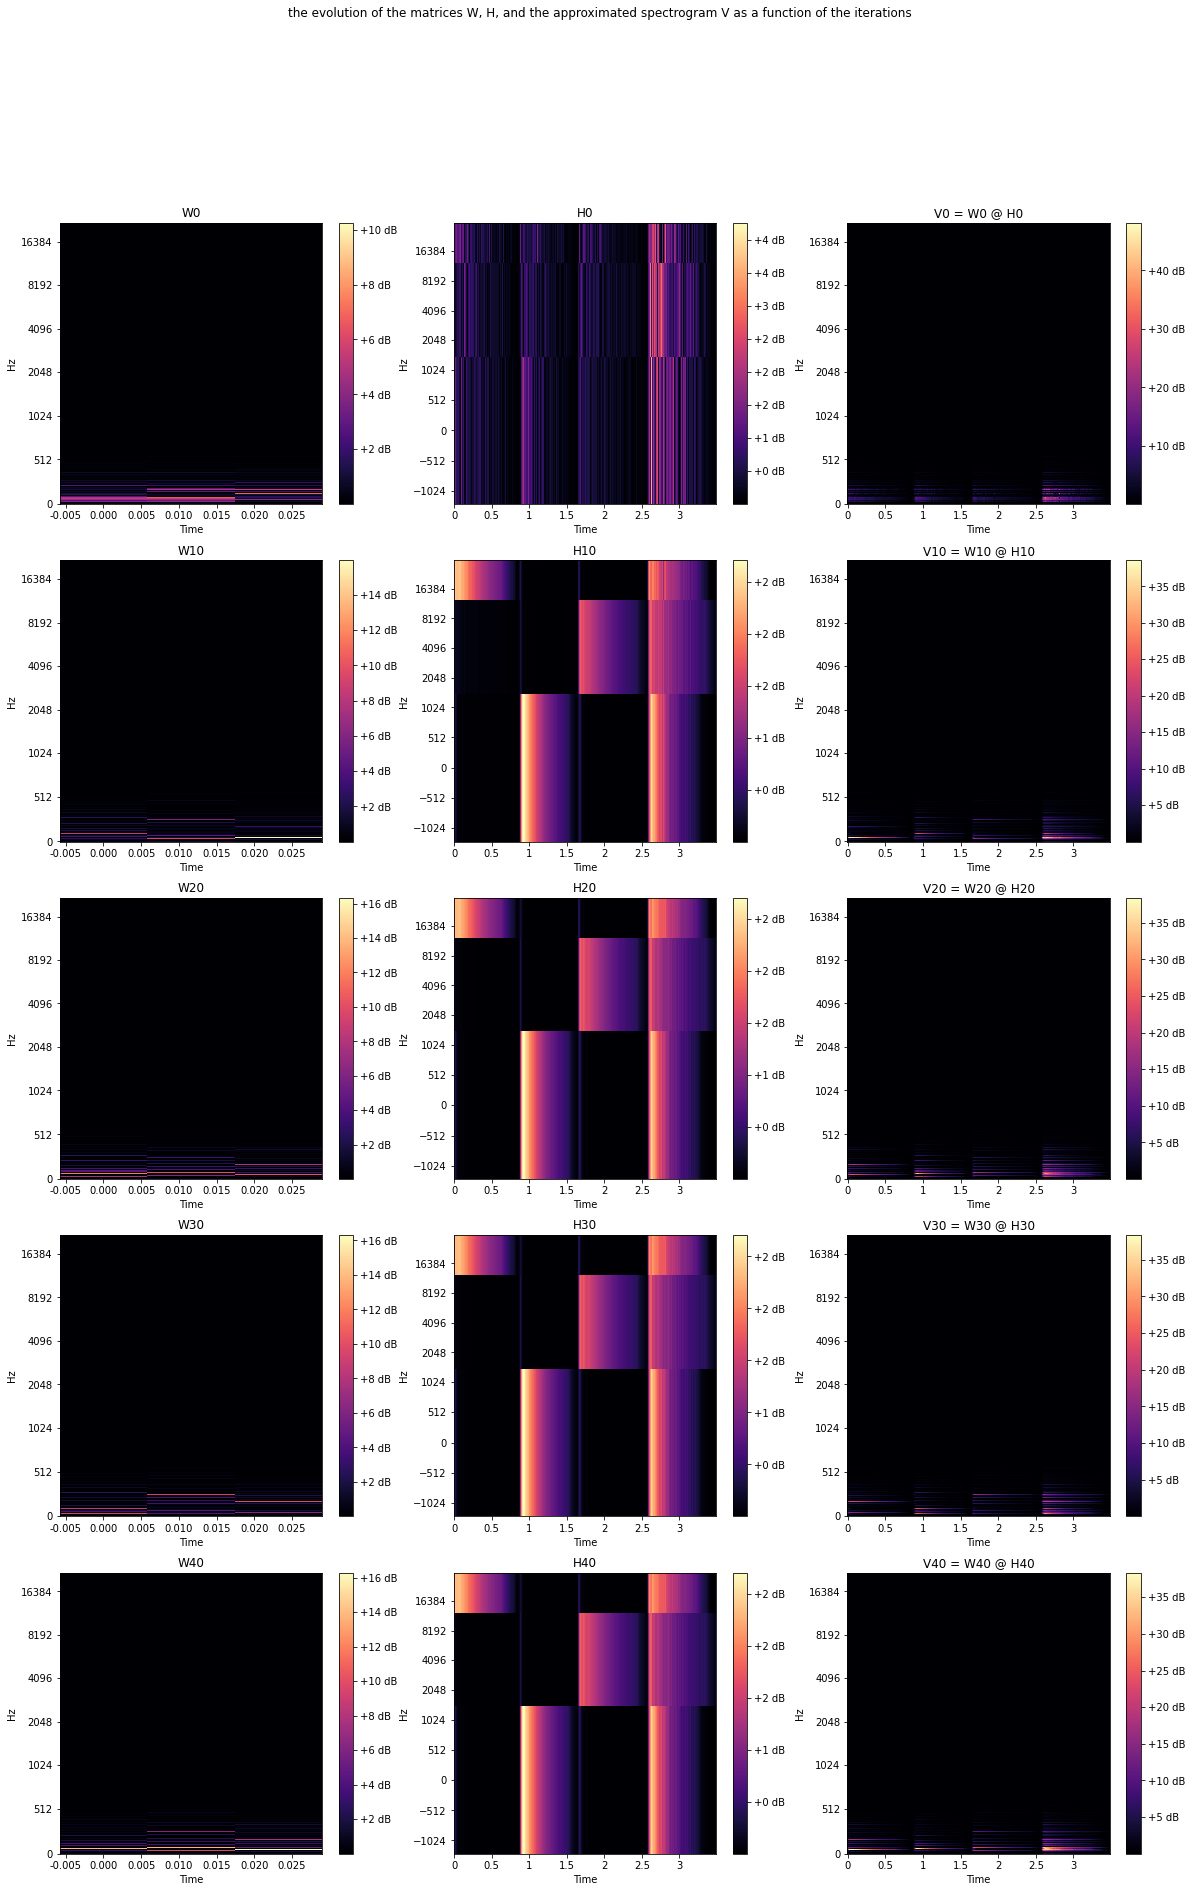

In [28]:
show_audio_spectrogrammes(W_H,
                          sr=sr,
                          suptitle='the evolution of the matrices W, H, and the approximated spectrogram V as a function of the iterations',
                          nb_plots=nb_plots, 
                          total_cols=total_cols, 
                          colorbar=True,
                          figsize=figsize)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


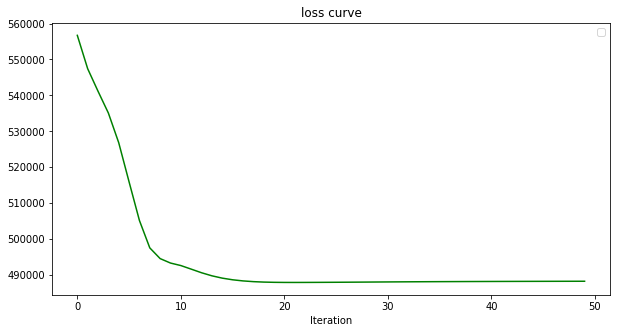

In [29]:
# display of the loss curve for each 'n' iteration

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(10, 5))
ax.set(title='loss curve', xlabel='Iteration')
ax.legend()
ax.plot(loss, color='g')

In [30]:
# From the matrices W, H, We implement the Wiener filtering to 
# calculate the spectrogram of the sound sources separately.
best_W, best_H = W_H['W40'], W_H['H40']
spectrogramme_of_sources = {}
for i in range(S):
    spectrogramme_of_sources['source ' + str(i)] = ((best_W[:, i].reshape(K, 1) @ best_H[i, :].reshape(1, N))/(best_W @ best_H)) * stft

In [31]:
total_cols = 3
nb_plots = S 
figsize = (20, 5)

c:\Users\Brani\anaconda3\envs\env_ML\lib\site-packages\librosa\util\decorators.py:88: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  return f(*args, **kwargs)


Text(0.5, 0.98, 'spectrogramme of sources')

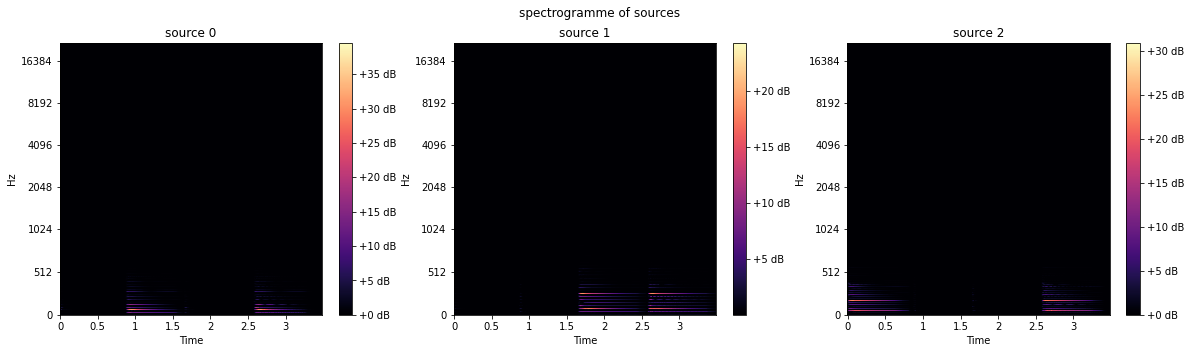

In [32]:
# Plot the evolution of the matrices W, H, and the approximated 
# spectrogram V as a function of the iterations

# compute number of cols & row  
# total_cols    = min(nb_axes, total_cols)
total_rows    = int(nb_plots / total_cols) + (1 if nb_plots % total_cols != 0 else 0)
# Create a grid of subplots.
fig, axes = plt.subplots(total_rows, total_cols, figsize=figsize)
# Create list of axes for easy iteration.
if isinstance(axes, np.ndarray):
    # https://stackoverflow.com/questions/46862861/what-does-axes-flat-in-matplotlib-do
    list_axes = list(axes.flat)
else:
    list_axes = [axes]
# it will helps to show total images as grid 

for (key, val), ax in zip(spectrogramme_of_sources.items(), list_axes):
    
    s = lb.display.specshow(val, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=None, ax=ax)
    ax.set(title= key)
    fig.colorbar(s, ax=ax, format='%+2.0f dB')
plt.suptitle('spectrogramme of sources')


In [33]:
# We will reconstruct the corresponding waveforms from the sound sources
# soectrograms. We will use the inverse short-time Fourier transform.

sound_waves = {}

for (_, val), i in zip(spectrogramme_of_sources.items(), range(len(list(spectrogramme_of_sources)))):
    sound_waves[f'sound {i}'] = librosa.istft(val)

In [34]:
total_cols = 1
nb_plots = S

figsize = (15, 15)

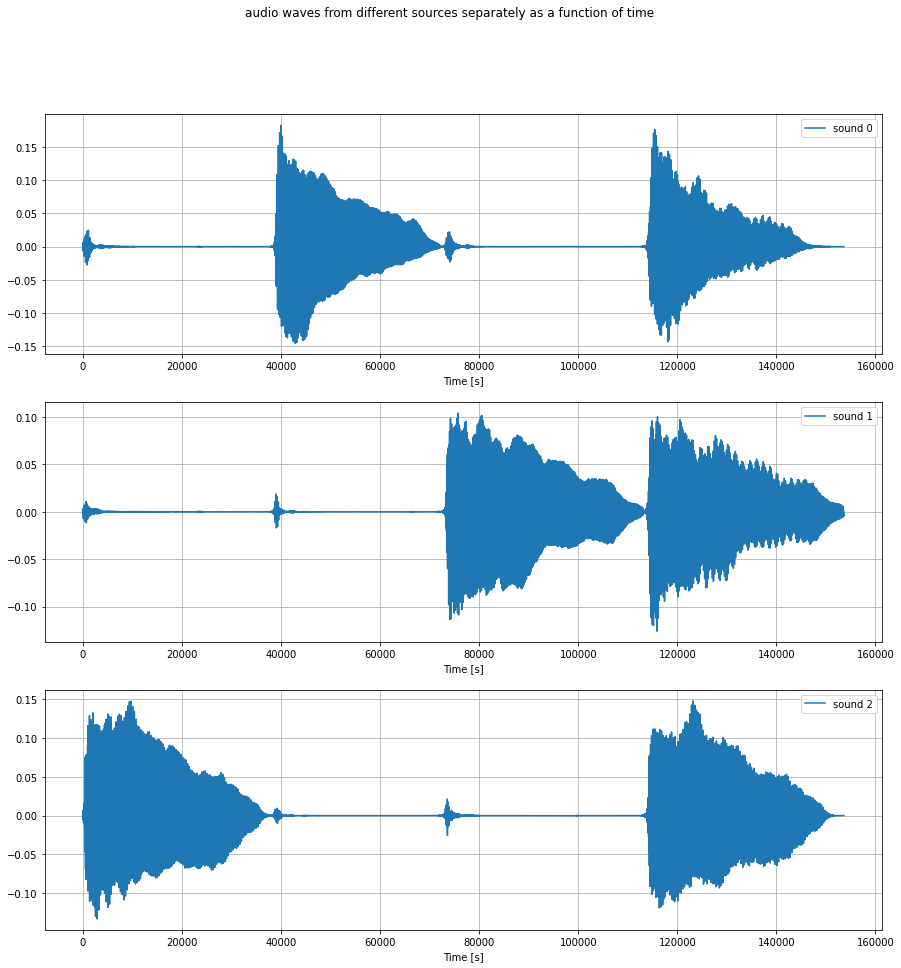

In [35]:
plot_audio_waves(waves=sound_waves,
                 suptitle='audio waves from different sources separately as a function of time', 
                 nb_plots=nb_plots, 
                 grid=True, 
                 total_cols=total_cols, 
                 figsize=figsize)


In [36]:
# display source 0
Audio(data=sound_waves['sound 0'], rate=sr)

In [37]:
# display source 1
Audio(data=sound_waves['sound 1'], rate=sr)

In [38]:
# display source 2
Audio(data=sound_waves['sound 2'], rate=sr)

- Commentaire
-  
-  
-  

In [39]:
W_H, loss = nmf(V=V, nb_sources=S, n_iter=50, B=0, n=10)

100%|██████████| 50/50 [00:01<00:00, 27.07it/s]


In [40]:
total_cols = 3
nb_plots = len(list(W_H))//2 * total_cols
figsize = (20, 30)

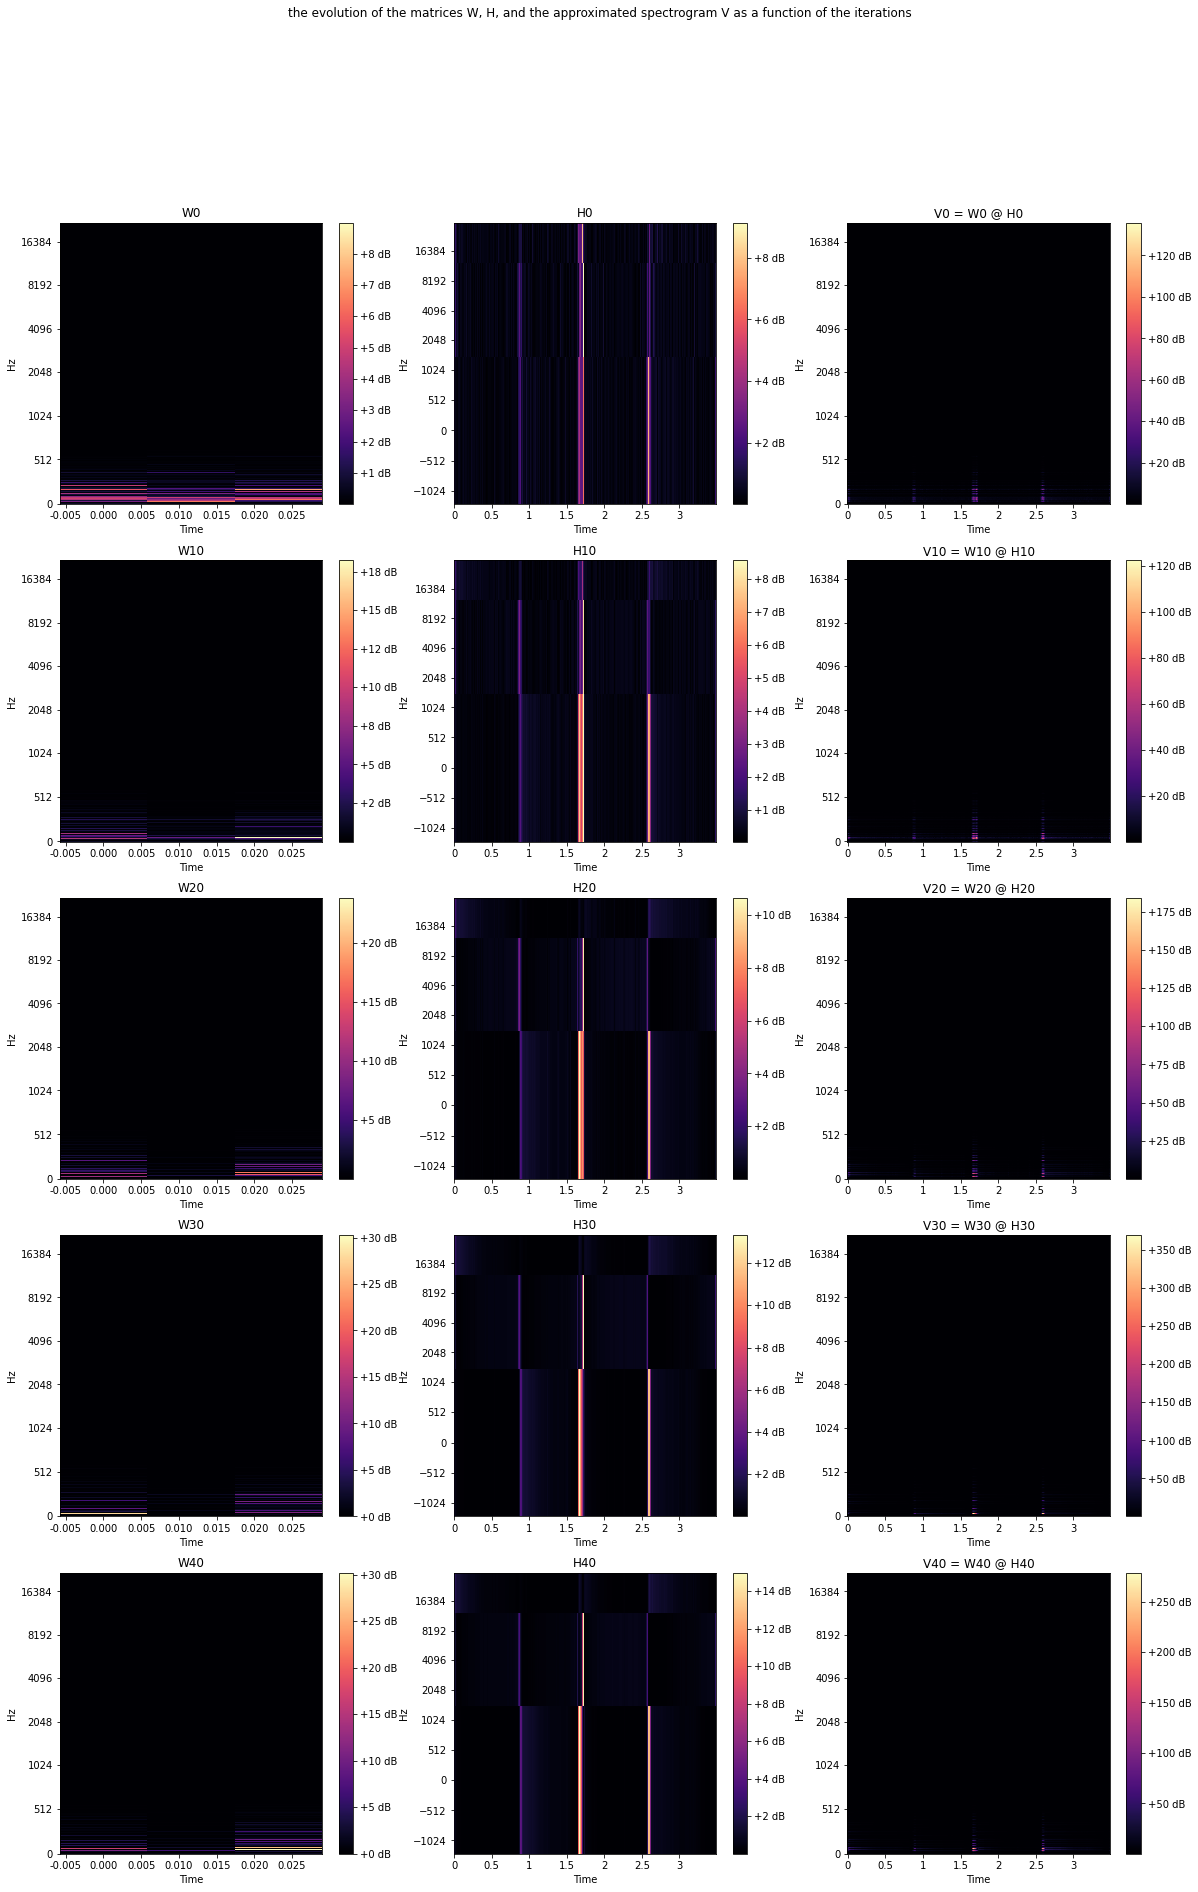

In [42]:
show_audio_spectrogrammes(W_H,
                          sr=sr,
                          suptitle='the evolution of the matrices W, H, and the approximated spectrogram V as a function of the iterations',
                          nb_plots=nb_plots, 
                          total_cols=total_cols, 
                          colorbar=True,
                          figsize=figsize)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


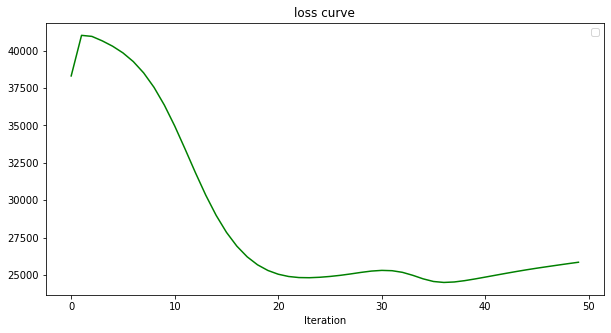

In [43]:
# display of the loss curve for each 'n' iteration

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(10, 5))
ax.set(title='loss curve', xlabel='Iteration')
ax.legend()
ax.plot(loss, color='g')

In [44]:
# From the matrices W, H, We implement the Wiener filtering to 
# calculate the spectrogram of the sound sources separately.
best_W, best_H = W_H['W40'], W_H['H40']
spectrogramme_of_sources = {}
for i in range(S):
    spectrogramme_of_sources['source ' + str(i)] = ((best_W[:, i].reshape(K, 1) @ best_H[i, :].reshape(1, N))/(best_W @ best_H)) * stft

In [45]:
total_cols = 3
nb_plots = S 
figsize = (20, 5)

Text(0.5, 0.98, 'spectrogramme of sources')

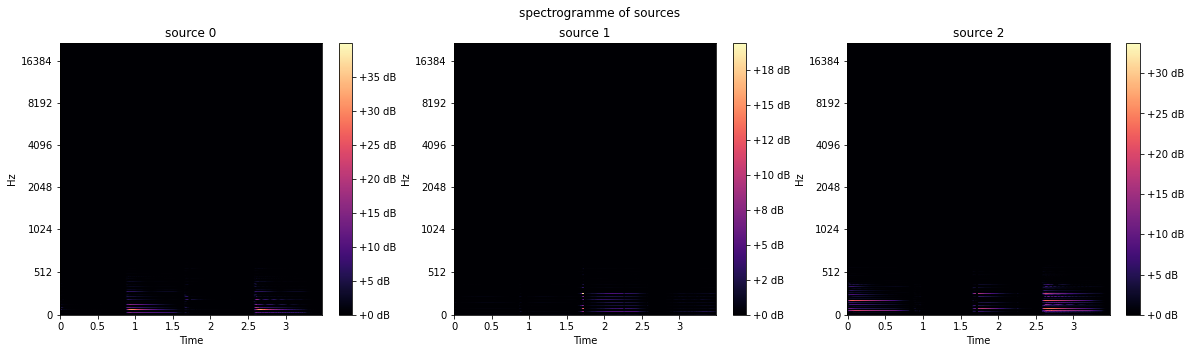

In [46]:
# Plot the evolution of the matrices W, H, and the approximated 
# spectrogram V as a function of the iterations

# compute number of cols & row  
# total_cols    = min(nb_axes, total_cols)
total_rows    = int(nb_plots / total_cols) + (1 if nb_plots % total_cols != 0 else 0)
# Create a grid of subplots.
fig, axes = plt.subplots(total_rows, total_cols, figsize=figsize)
# Create list of axes for easy iteration.
if isinstance(axes, np.ndarray):
    # https://stackoverflow.com/questions/46862861/what-does-axes-flat-in-matplotlib-do
    list_axes = list(axes.flat)
else:
    list_axes = [axes]
# it will helps to show total images as grid 

for (key, val), ax in zip(spectrogramme_of_sources.items(), list_axes):
    
    s = lb.display.specshow(val, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=None, ax=ax)
    ax.set(title= key)
    fig.colorbar(s, ax=ax, format='%+2.0f dB')
plt.suptitle('spectrogramme of sources')


In [47]:
# We will reconstruct the corresponding waveforms from the sound sources
# soectrograms. We will use the inverse short-time Fourier transform.

sound_waves = {}

for (_, val), i in zip(spectrogramme_of_sources.items(), range(len(list(spectrogramme_of_sources)))):
    sound_waves[f'sound {i}'] = librosa.istft(val)

In [48]:
total_cols = 1
nb_plots = S

figsize = (15, 15)

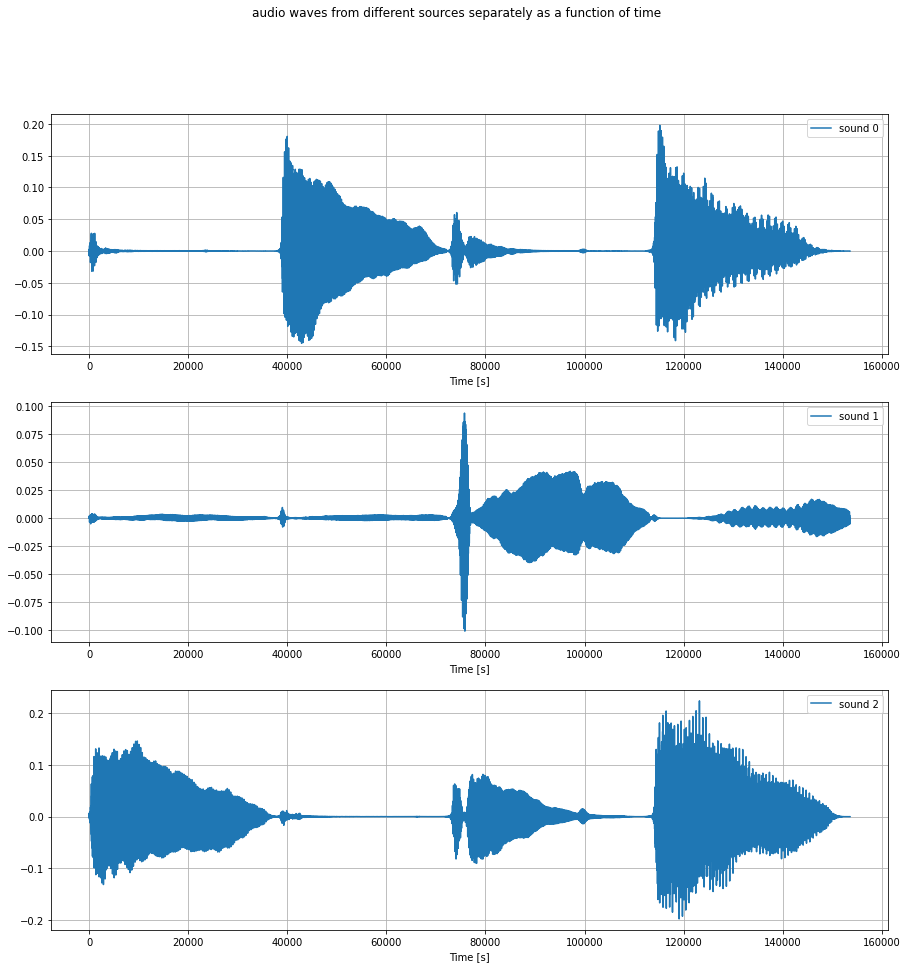

In [49]:
plot_audio_waves(waves=sound_waves,
                 suptitle='audio waves from different sources separately as a function of time', 
                 nb_plots=nb_plots, 
                 grid=True, 
                 total_cols=total_cols, 
                 figsize=figsize)


In [50]:
# display source 0
Audio(data=sound_waves['sound 0'], rate=sr)

In [51]:
# display source 1
Audio(data=sound_waves['sound 1'], rate=sr)

In [52]:
# display source 2
Audio(data=sound_waves['sound 2'], rate=sr)

$Q8$

On prend : s = 4 et betha=2

In [53]:
S = 4

In [54]:

W_H, loss = nmf(V=V, nb_sources=S, n_iter=50, B=2, n=10)

100%|██████████| 50/50 [00:00<00:00, 69.89it/s]


In [55]:
total_cols = 3
nb_plots = len(list(W_H))//2 * total_cols
figsize = (20, 30)

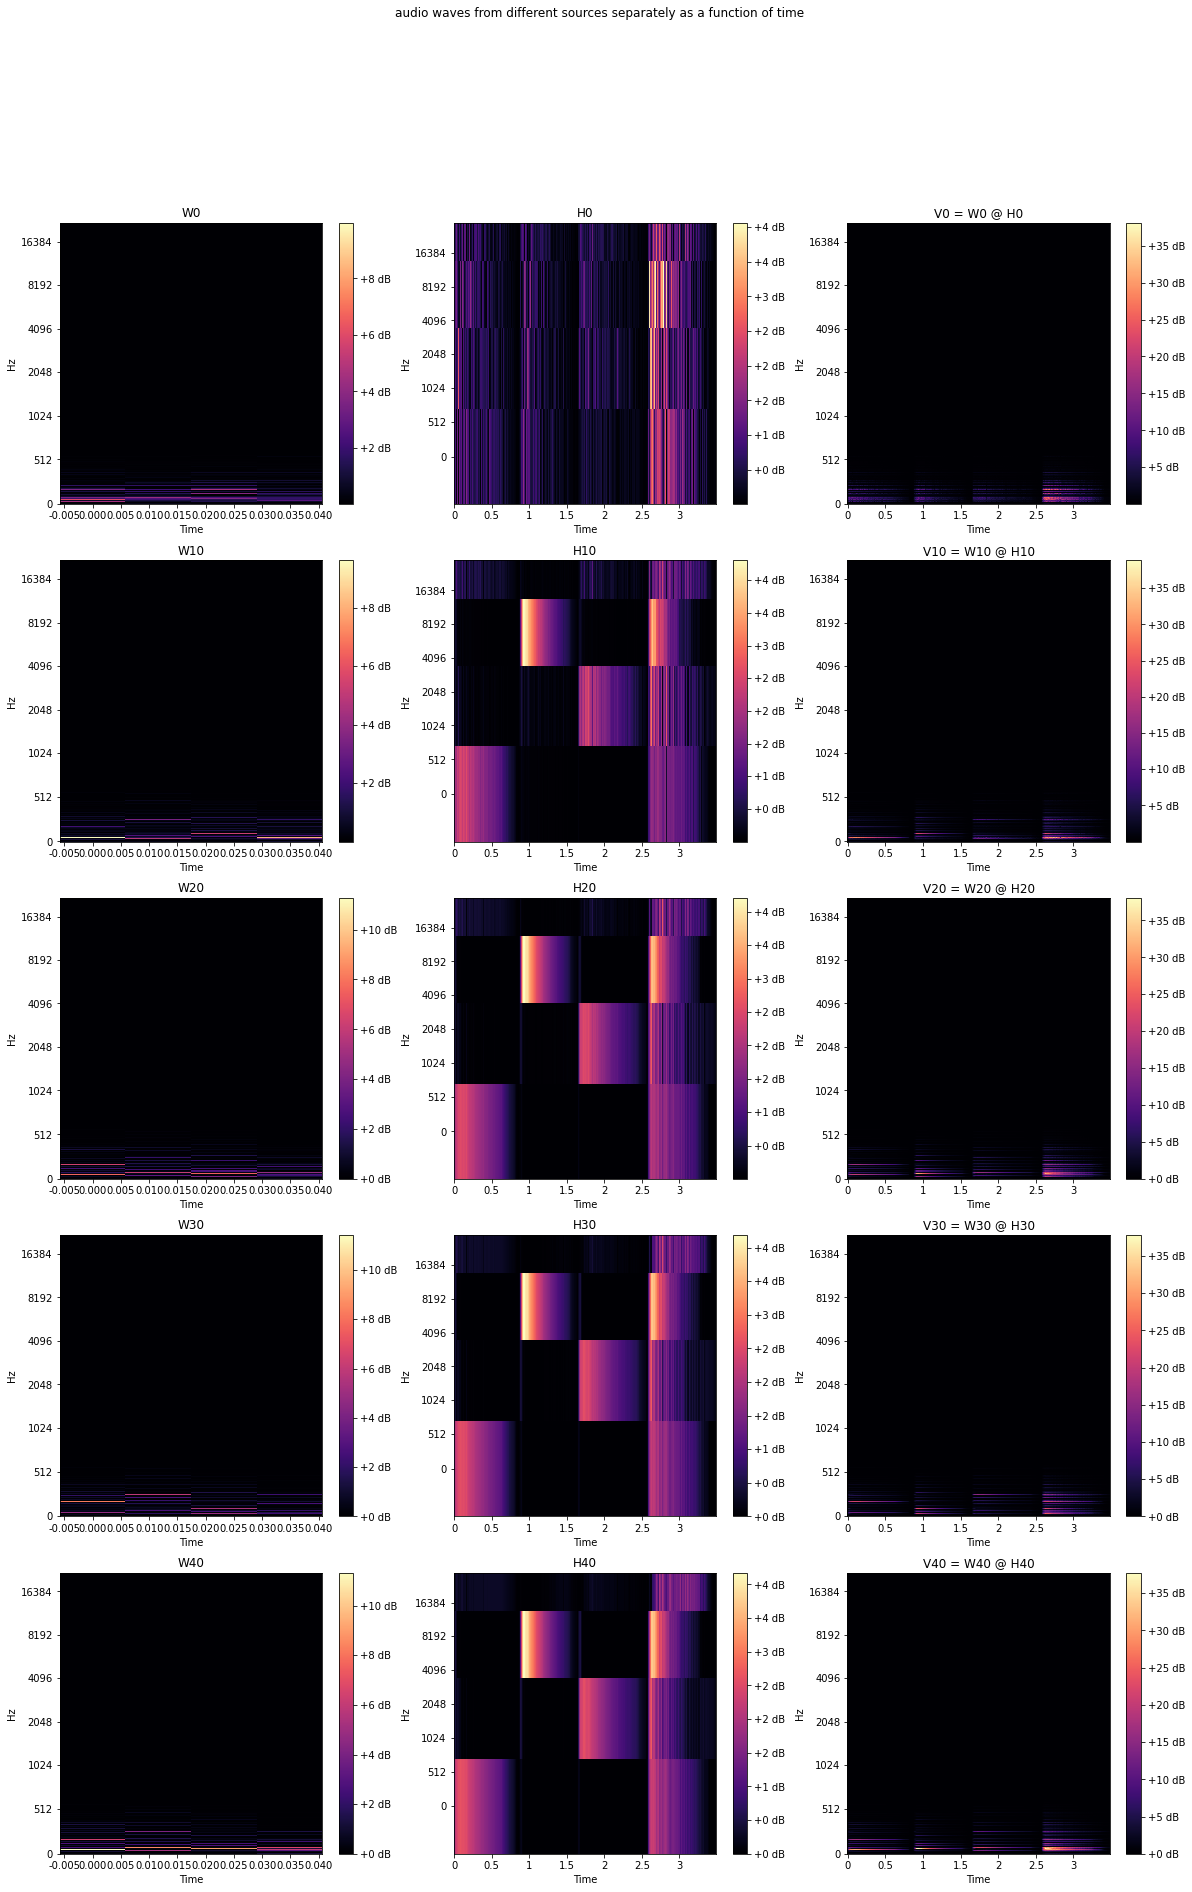

In [56]:
show_audio_spectrogrammes(W_H,
                          sr=sr,
                          suptitle='audio waves from different sources separately as a function of time',
                          nb_plots=nb_plots, 
                          total_cols=total_cols, 
                          colorbar=True,
                          figsize=figsize)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


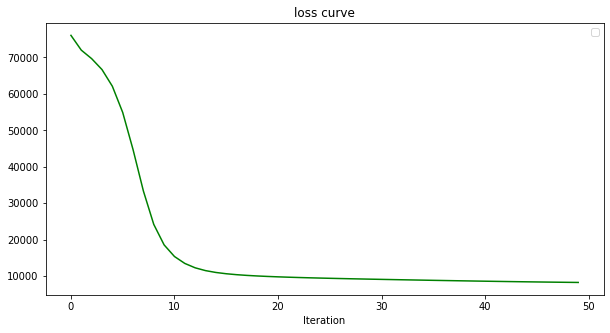

In [57]:
# display of the loss curve for each 'n' iteration

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(10, 5))
ax.set(title='loss curve', xlabel='Iteration')
ax.legend()
ax.plot(loss, color='g')

In [58]:
# From the matrices W, H, We implement the Wiener filtering to 
# calculate the spectrogram of the sound sources separately.
best_W, best_H = W_H['W40'], W_H['H40']
spectrogramme_of_sources = {}
for i in range(S):
    spectrogramme_of_sources['source ' + str(i)] = ((best_W[:, i].reshape(K, 1) @ best_H[i, :].reshape(1, N))/(best_W @ best_H)) * stft

In [59]:
total_cols = S
nb_plots = S 
figsize = (20, 5)

Text(0.5, 0.98, 'spectrogramme of sources')

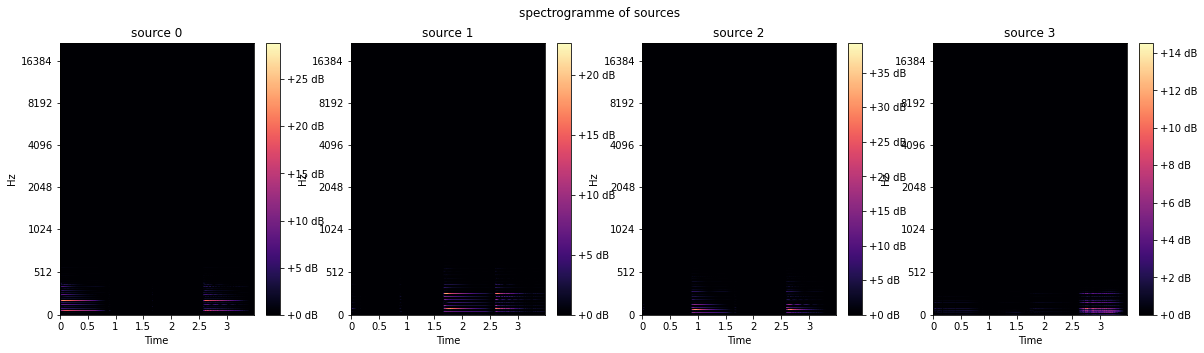

In [60]:
# Plot the evolution of the matrices W, H, and the approximated 
# spectrogram V as a function of the iterations

# compute number of cols & row  
# total_cols    = min(nb_axes, total_cols)
total_rows    = int(nb_plots / total_cols) + (1 if nb_plots % total_cols != 0 else 0)
# Create a grid of subplots.
fig, axes = plt.subplots(total_rows, total_cols, figsize=figsize)
# Create list of axes for easy iteration.
if isinstance(axes, np.ndarray):
    # https://stackoverflow.com/questions/46862861/what-does-axes-flat-in-matplotlib-do
    list_axes = list(axes.flat)
else:
    list_axes = [axes]
# it will helps to show total images as grid 

for (key, val), ax in zip(spectrogramme_of_sources.items(), list_axes):
    
    s = lb.display.specshow(val, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=None, ax=ax)
    ax.set(title= key)
    fig.colorbar(s, ax=ax, format='%+2.0f dB')
plt.suptitle('spectrogramme of sources')

In [61]:
# We will reconstruct the corresponding waveforms from the sound sources
# soectrograms. We will use the inverse short-time Fourier transform.

sound_waves = {}

for (_, val), i in zip(spectrogramme_of_sources.items(), range(len(list(spectrogramme_of_sources)))):
    sound_waves[f'sound {i}'] = librosa.istft(val)

In [62]:
total_cols = 1
nb_plots = S

figsize = (15, 15)

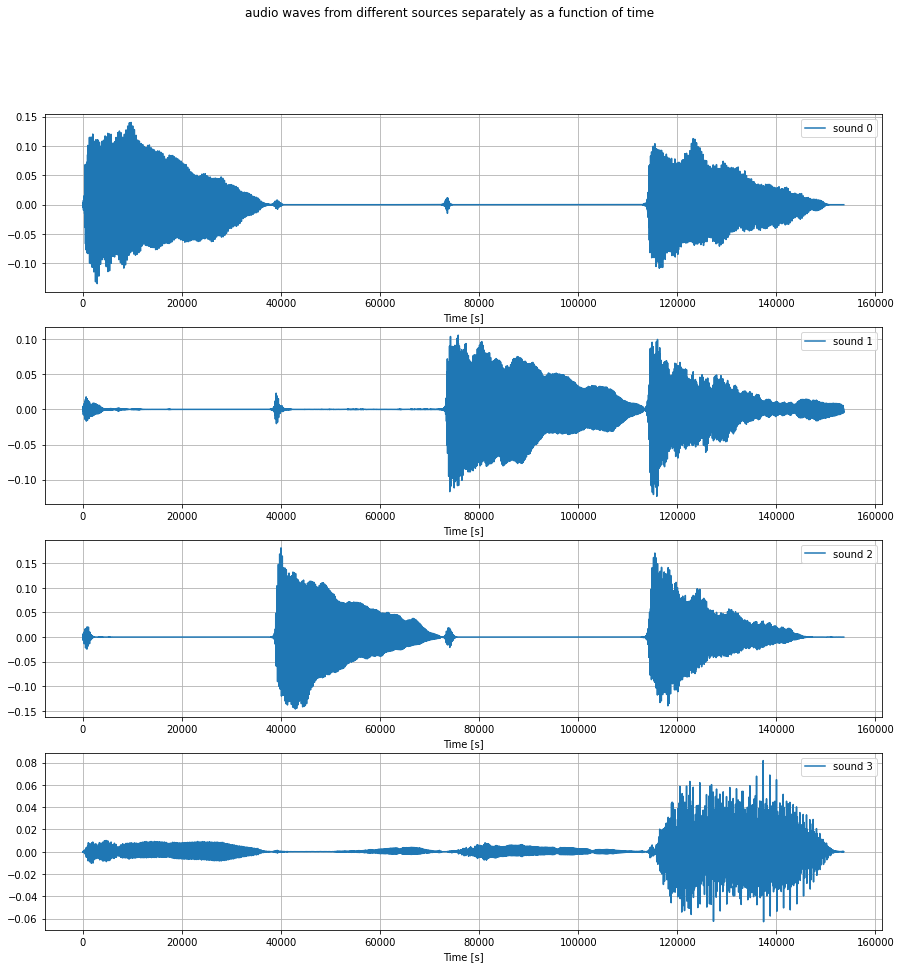

In [63]:
plot_audio_waves(waves=sound_waves,
                 suptitle='audio waves from different sources separately as a function of time', 
                 nb_plots=nb_plots, 
                 grid=True, 
                 total_cols=total_cols, 
                 figsize=figsize)

In [64]:
# display source 0
Audio(data=sound_waves['sound 0'], rate=sr)

In [65]:
# display source 1
Audio(data=sound_waves['sound 1'], rate=sr)

In [66]:
# display source 2
Audio(data=sound_waves['sound 2'], rate=sr)

In [67]:
# display source 3
Audio(data=sound_waves['sound 3'], rate=sr)